In [9]:
%pip uninstall -y keras keras-nightly keras-preprocessing tf-keras tensorflow
%pip install keras==2.11.0 tf-keras transformers==4.36.2 tokenizers==0.13.3 sentence-transformers==2.2.2 bertopic==0.15.0 keybert==0.7.0 scikit-learn pandas


Note: you may need to restart the kernel to use updated packages.


  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tf_keras-2.19.0-py3-none-any.whl (1.7 MB)
  Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
  Using cached tokenizers-0.13.3-cp39-cp39-win_amd64.whl (3.5 MB)
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached bertopic-0.15.0-py2.py3-none-any.whl (143 kB)
  Using cached keybert-0.7.0.tar.gz (21 kB)
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of keras to determine which version is compatible with other requirements. This could take a while.

The conflict is caused by:
    The user requested tokenizers==0.13.3
    transformers 4.36.2 depends on tokenizers<0.19 and >=0.14

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the depe

ERROR: Cannot install tokenizers==0.13.3 and transformers==4.36.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/user_guide/#fixing-conflicting-dependencies


In [10]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT

In [11]:
# Step 1: Load CSV
df = pd.read_csv("..\data\youtube_comments\jack_vs_calley_1000.csv")  # <-- change filename if needed
texts = df["text"].dropna().astype(str).tolist()  # make sure column is named 'comment'



In [12]:
# Step 2: Fit BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model)
topics, probs = topic_model.fit_transform(texts)

# Step 3: Get BERTopic default labels
bertopic_labels = topic_model.get_topic_info()



In [13]:
# Step 4: Alternative labeling - KeyBERT based
kw_model = KeyBERT(model=embedding_model)

def get_custom_labels_per_topic(top_n=5):
    custom_labels = {}
    for topic in bertopic_labels['Topic'].unique():
        if topic == -1:  # Skip outliers
            continue
        docs_in_topic = [texts[i] for i, t in enumerate(topics) if t == topic]
        joined_docs = " ".join(docs_in_topic)
        keywords = kw_model.extract_keywords(joined_docs, top_n=top_n, stop_words='english')
        custom_labels[topic] = [kw[0] for kw in keywords]
    return custom_labels

custom_labels = get_custom_labels_per_topic()

def compute_jaccard(set1, set2):
    set1, set2 = set(set1), set(set2)
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0


def compare_labels_with_jaccard(bertopic_model, custom_labels):
    comparison = []
    for topic in custom_labels:
        bertopic_words = [word for word, _ in bertopic_model.get_topic(topic)]
        custom_words = custom_labels[topic]
        overlap = set(bertopic_words) & set(custom_words)
        jaccard = compute_jaccard(bertopic_words, custom_words)
        comparison.append({
            "Topic": topic,
            "BERTopic Label": bertopic_words,
            "Custom Label": custom_words,
            "Overlap": list(overlap),
            "Overlap Count": len(overlap),
            "Jaccard Score": round(jaccard, 3)
        })
    return pd.DataFrame(comparison)



In [16]:
comparison_df = compare_labels_with_jaccard(topic_model, custom_labels)

# Step 6: Show results
display(comparison_df.head(25))

,Topic,BERTopic Label,Custom Label,Overlap,Overlap Count,Jaccard Score
0,0,"[calley, is, he, to, and, jack, the, his, of, ...","[calley, cally, calleys, calle, phoney]",[calley],1,0.071
1,1,"[jack, to, he, is, hold, and, guy, this, so, but]","[jack, jackjack, jackkkkkkkk, jacked, jackhole]",[jack],1,0.071
2,2,"[the, and, to, that, covid, jab, of, vaccine, ...","[vaccine, vaccines, vaccinations, vaccinate, p...","[vaccines, vaccine]",2,0.154
3,3,"[pharma, the, big, is, their, doctors, and, mo...","[eugenics, lobbyist, pharma, lobbyists, medica...",[pharma],1,0.071
4,4,"[jab, the, trump, we, rfk, to, deporting, that...","[jabs, jab, jabbed, vaccines, ban]",[jab],1,0.071
5,5,"[lobbyist, is, the, to, lobbyists, this, and, ...","[lobbyist, lobbyists, bribery, corrupt, politi...","[lobbyist, lobbyists]",2,0.154
6,6,"[transparency, fraud, the, people, need, of, d...","[accountability, transparency, prosecute, just...","[justice, transparency]",2,0.154
7,7,"[he, to, jack, the, his, him, and, of, conspir...","[jack, conspiracies, conspiracy, shill, trump]","[conspiracy, jack]",2,0.154
8,8,"[each, you, other, talking, over, it, to, like...","[conversation, debating, talk, talking, monolo...","[talking, conversation]",2,0.154
9,9,"[globalist, woo, globalists, america, guy, is,...","[globalist, globalists, patriotism, propaganda...","[globalists, globalist]",2,0.154


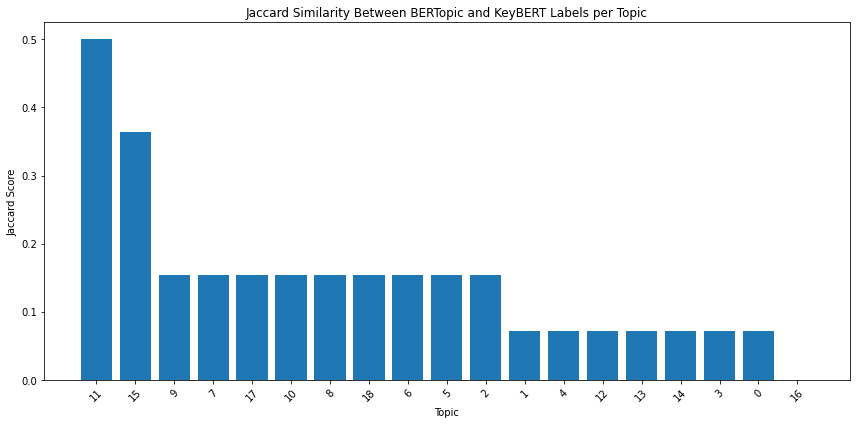

In [15]:
import matplotlib.pyplot as plt

# מיין לפי ציון Jaccard
comparison_df_sorted = comparison_df.sort_values(by="Jaccard Score", ascending=False)

# צייר גרף
plt.figure(figsize=(12, 6))
plt.bar(comparison_df_sorted["Topic"].astype(str), comparison_df_sorted["Jaccard Score"])
plt.xticks(rotation=45)
plt.xlabel("Topic")
plt.ylabel("Jaccard Score")
plt.title("Jaccard Similarity Between BERTopic and KeyBERT Labels per Topic")
plt.tight_layout()
plt.show()